# ModelHub Template and SEIRD model example

This notebook implements the SEIRD Model using data from the covid19za data repository. 

*Authors:* Tshepiso Mokoena [Github: [@TshepisoMokoena](https://github.com/TshepisoMokoena)] & Vukosi Marivate [Github: [@vukosim](https://github.com/vukosi), Twitter: [@vukosi](https://twitter.com/vukosi)]
*Date:* 25 May 2020

### Model Description

TODO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import odeint

%matplotlib inline 

## SEIRD differential equations

* TODO: Reference

In [2]:
# SEIR Differenctial equations
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

## Load South Africa Data

In [3]:
za_confirmed_url = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_confirmed.csv"
za_recoveries_url = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_recoveries.csv"
za_deaths_url = "https://raw.githubusercontent.com/dsfsi/covid19za/master/data/covid19za_provincial_cumulative_timeline_deaths.csv"

### ZA Confirmed Infections

In [4]:
df_za_infections = pd.read_csv(za_confirmed_url, parse_dates=['date'], dayfirst=True)
df_za_infections = df_za_infections[['date','total']]
df_za_infections.rename(columns={'total':'total_infections'}, inplace=True)
df_za_infections.set_index('date',inplace=True)
df_za_infections.head()

,total_infections
date,
2020-03-05,1
2020-03-07,2
2020-03-08,3
2020-03-09,7
2020-03-11,13


### ZA Recoveries

In [5]:
df_za_recoveries = pd.read_csv(za_recoveries_url, parse_dates=['date'], dayfirst=True)
df_za_recoveries = df_za_recoveries[['date','total']]
df_za_recoveries.rename(columns={'total':'total_recoveries'}, inplace=True)
df_za_recoveries.set_index('date',inplace=True)
df_za_recoveries.head()

,total_recoveries
date,
2020-04-17,903
2020-04-18,903
2020-04-19,903
2020-04-20,1055
2020-04-21,1055


### ZA Deaths

In [6]:
df_za_deaths = pd.read_csv(za_deaths_url, parse_dates=['date'], dayfirst=True)
df_za_deaths = df_za_deaths[['date','total']]
df_za_deaths.rename(columns={'total':'total_deaths'}, inplace=True)
df_za_deaths.set_index('date',inplace=True)
df_za_deaths.head()

,total_deaths
date,
2020-03-27,1
2020-03-28,2
2020-03-30,3
2020-03-31,5
2020-04-03,9


## Get Population Data

* TODO: Reference

In [7]:
population_url = "https://raw.githubusercontent.com/datasets/population/master/data/population.csv"
df_population = pd.read_csv(population_url)
df_population.head()

,Country Name,Country Code,Year,Value
0,Arab World,ARB,1960,92197753
1,Arab World,ARB,1961,94724510
2,Arab World,ARB,1962,97334442
3,Arab World,ARB,1963,100034179
4,Arab World,ARB,1964,102832760


## Main Model: Compute SEIRDs for South Africa

### Current Population Size

In [8]:
country = "South Africa"
N = df_population.loc[(df_population["Country Name"] == country) & (df_population["Year"] == 2018)]["Value"].values 

### Set initial conditions 

In [9]:
no_days_to_death = 14 # number of days to death after getting infection
D = 14 # how many days infection lasts for
alpha = 0.002 # death rate
no_days_to_death = 14  # How long an
incubation_period =  1 # number of days an exposed individual becomes infectiou

### Get data from this date

In [10]:
date = "2020-05-20"
no_infections = df_za_infections.loc[date].values
no_deaths = df_za_deaths.loc[date].values
no_recoveries = df_za_recoveries.loc[date].values

### The SEIRD Model - Initial Conditions

In [11]:
R_0 = no_infections/no_recoveries

gamma = 1.0 / D
delta = 1.0 / incubation_period # incubation period of five days
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
rho = 1/no_days_to_death  # days from infection until death    
S0, E0, I0, R0, D0 = N, 0, no_infections, no_recoveries, no_deaths  # initial conditions: one exposed

t = np.linspace(0, 600, 150) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions v

### Solve differential equation with chosen initial conditions

In [12]:
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

### Plot SEIRD curves 

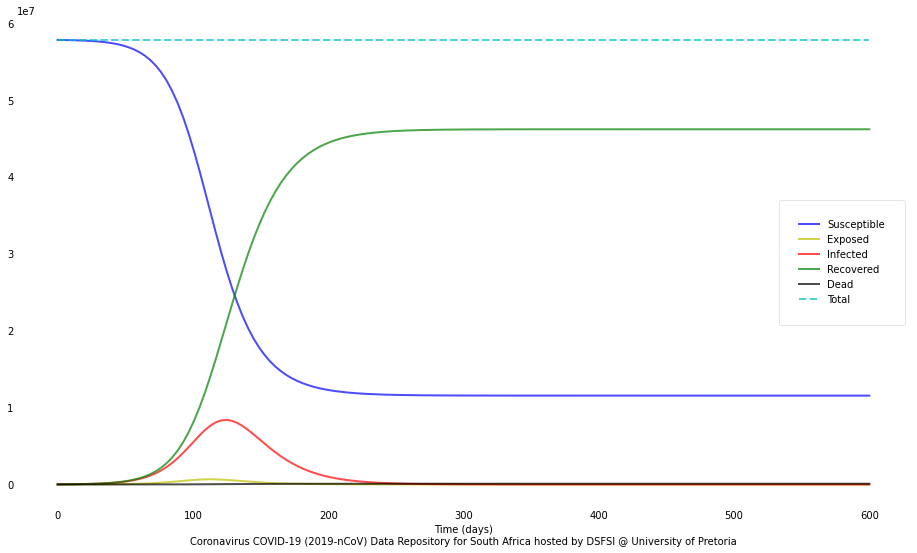

In [13]:
f, ax = plt.subplots(1,1,figsize=(16,9))
ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
ax.set_xlabel('Time (days)\nCoronavirus COVID-19 (2019-nCoV) Data Repository for South Africa hosted by DSFSI @ University of Pretoria')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(borderpad=2.0)
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

# Data Ouput

TODO: Write data to modelhub/output-data/